This tutorial used Fourier-Galerkin method to solve a linear elasticity problem of a circular inclusion in a square matrix. The inclusion is a material with a different elastic properties than the matrix.

In [ ]:
import jax

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_platforms", "cpu")
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
from functools import partial

import equinox as eqx
import jax.numpy as jnp
import numpy as np
from jax import Array



In this example, we solve a linear elasticity problem of a circular inclusion in a square matrix. The inclusion is a material with a different elastic properties than the matrix. We use the Fourier-Galerkin method to solve the problem.

We import the necessary modules and set up the environment. The module `xpektra` contains the operators and solvers for the Fourier-Galerkin method. We import the `SpectralSpace`, `SpectralOperator`, `make_field`, `RotatedDifference`, `FFTTransform`, `conjugate_gradient`, and `NewtonSolver` modules to create the operators and solvers.


In [ ]:
from xpektra import (
    SpectralSpace,
    make_field,
)
from xpektra.projection_operator import GalerkinProjection
from xpektra.scheme import RotatedDifference
from xpektra.solvers.nonlinear import (  # noqa: E402
    NewtonSolver,
    newton_krylov_solver,
)
from xpektra.spectral_operator import SpectralOperator
from xpektra.transform import FFTTransform

We define the grid size and the length of the RVE and construct the structure of the RVE.

In [7]:
N = 199
ndim = 2
length = 1


# Create phase indicator (cylinder)
x = np.linspace(-0.5, 0.5, N)

if ndim == 3:
    Y, X, Z = np.meshgrid(x, x, x, indexing="ij")  # (N, N, N) grid
    phase = jnp.where(X**2 + Z**2 <= (0.2 / np.pi), 1.0, 0.0)  # 20% vol frac
else:
    X, Y = np.meshgrid(x, x, indexing="ij")  # (N, N) grid
    phase = jnp.where(X**2 + Y**2 <= (0.2 / np.pi), 1.0, 0.0)

## Defining the Operators

In order to define the Fourier-Galerkin operator, we first define the spectral space, the transform operators, and the spectral operators. We use the `SpectralSpace` class to define the spectral space, the `Fourier` class to define the FFT and IFFT operators, and the `RotatedDifference` class to define the spatial operators.

Finally we define the Spectral Operators using the `SpectralOperator` class which takes the spectral space and the spatial operators as input.



In [8]:

fft_transform = FFTTransform(dim=ndim)
space = SpectralSpace(
    lengths=(length,) * ndim, shape=phase.shape, transform=fft_transform
)
rotated_scheme = RotatedDifference(space=space)

op = SpectralOperator(
    scheme=rotated_scheme,
    space=space,
)

Next, we define the material parameters.

In [9]:
# Material parameters [grids of scalars, shape (N,N,N)]
lambda1, lambda2 = 10.0, 1000.0
mu1, mu2 = 0.25, 2.5
lambdas = lambda1 * (1.0 - phase) + lambda2 * phase
mu = mu1 * (1.0 - phase) + mu2 * phase

The linear elasticity strain energy is given as

$$
W = \frac{1}{2} \int_{\Omega}  (\lambda \text{tr}(\epsilon)^2+ \mu \text{tr}(\epsilon : \epsilon ) ) d\Omega
$$

We define a python function to compute the strain energy and then use the `jax.jacrev` function to compute the stress tensor.

In [10]:
dofs_shape = make_field(dim=ndim, shape=phase.shape, rank=2).shape


@eqx.filter_jit
def strain_energy(eps_flat: Array) -> Array:
    eps = eps_flat.reshape(dofs_shape)
    eps_sym = 0.5 * (eps + op.trans(eps))
    energy = 0.5 * jnp.multiply(lambdas, op.trace(eps_sym) ** 2) + jnp.multiply(
        mu, op.trace(op.dot(eps_sym, eps_sym))
    )
    return energy.sum()


compute_stress = jax.jacrev(strain_energy)

In `xpektra`, we provide various projection operators. Here we use the `GalerkinProjection` operator to define the Fourier-Galerkin operator. A projecction operator projects a field onto a subspace. The Fourier-Galerkin operator projects the stress field onto the space of divergence-free fields in the Fourier space. To define a Projection operator, we need to provide the scheme to tell how to spatial differentiate. 

In [11]:
Ghat = GalerkinProjection(scheme=rotated_scheme)

## Defining the Residual and Jacobian Functions

We now define the residual function and the Jacobian function for the Newton solver. The residual function computes the residual of the problem based on the given macro strain. It takes only the flattened vector of fluctuation strain and a macro strain. The Jacobian function represents the Jacobian-vector product.

The total strain is given as

$$\mathbf{\varepsilon} = \tilde{\mathbf{\varepsilon}} + \mathbf{\varepsilon}_\text{macro}^{i}  $$

where $\tilde{\mathbf{\varepsilon}}$ is the fluctuation strain and $\mathbf{\varepsilon}_\text{macro}^{i}$ is the applied macro strain at iteration $i$.

The residual is given as

$$R(\tilde{\mathbf{\varepsilon}}, \varepsilon_\text{macro}) = \mathcal{F}^{-1} \left( \mathbb{G}:\mathcal{F}(\mathbf{\sigma}(\tilde{\varepsilon} + \varepsilon_\text{macro}^{i})) \right) $$

where $\mathbb{G}$ is the Fourier-Galerkin operator defined earlier, $\mathcal{F}$ and $\mathcal{F}^{-1}$ are the FFT and IFFT operators respectively, and $\mathbf{\sigma}$ is the stress tensor computed from the strain energy function defined earlier.

We can define the residual at $\tilde{\varepsilon} + \Delta \tilde{\varepsilon}$ as

$$R(\tilde{\mathbf{\varepsilon}} + \Delta \tilde{\mathbf{\varepsilon}}, \varepsilon_\text{macro}) = \mathcal{F}^{-1} \left( \mathbb{G}:\mathcal{F}(\mathbf{\sigma}(\tilde{\varepsilon} + \Delta \tilde{\mathbf{\varepsilon}} + \varepsilon_\text{macro}^{i})) \right) $$

USing the Taylor expansion, we can write

$$R(\tilde{\mathbf{\varepsilon}} + \Delta \tilde{\mathbf{\varepsilon}}, \varepsilon_\text{macro}) \approx R(\tilde{\mathbf{\varepsilon}}, \varepsilon_\text{macro}) + \frac{\partial R}{\partial \tilde{\mathbf{\varepsilon}}} \Delta \tilde{\mathbf{\varepsilon}} $$

Below we define the residual function and the Jacobian function using the above equations.

We use `op.forward` and `op.inverse` methods to apply the FFT and IFFT operators respectively.


In [12]:
@eqx.filter_jit
def residual_fn(eps_fluc_flat: Array, macro_strain: float) -> Array:
    """
    A function that computes the residual of the problem based on the given macro strain.
    It takes only the flattened vector of fluctuation strain and a macro strain.

    Args:
        eps_fluc_flat: Flattened vector of fluctuation strain.
        macro_strain: Macro strain.

    Returns:
        Residual field.
    """

    eps_fluc = eps_fluc_flat.reshape(dofs_shape)
    eps_macro = jnp.zeros(dofs_shape)
    eps_macro = eps_macro.at[:, :, 0, 0].set(macro_strain)
    eps_macro = eps_macro.at[:, :, 1, 1].set(macro_strain)
    eps_total = eps_fluc + eps_macro
    eps_flat = eps_total.reshape(-1)
    sigma = compute_stress(eps_flat)
    residual_field = op.inverse(Ghat.project(op.forward(sigma.reshape(dofs_shape))))
    return jnp.real(residual_field).reshape(-1)


@eqx.filter_jit
def jacobian_fn(deps_flat: Array) -> Array:
    """
    The Jacobian is a linear operator, so its represents the Jacobian-vector product.
    For this linear elastic problem, we use the stress relation to compute the Jacobian.

    Args:
        deps_flat: The flattened displacement gradient field.

    Returns:
        The flattened Jacobian-vector product.
    """

    deps_flat = deps_flat.reshape(-1)
    dsigma = compute_stress(deps_flat)
    jvp_field = op.inverse(Ghat.project(op.forward(dsigma.reshape(dofs_shape))))
    return jnp.real(jvp_field).reshape(-1)

## Solving the Problem using Newton-Krylov Solver

We will use the Newton-Krylov solver to solve the problem. The Newton-Krylov solver requires the residual function and the Jacobian function as input.

Finally, we define the macro strain and solve the problem using the Newton-Krylov solver. 

In [15]:
applied_strains = jnp.diff(jnp.linspace(0, 1e-2, num=5))


solver = NewtonSolver(
    tol=1e-8,
    max_iter=20,
    krylov_solver=conjugate_gradient,
    krylov_tol=1e-8,
    krylov_max_iter=20,
)

eps_fluc_init = jnp.array(make_field(dim=2, shape=phase.shape, rank=2))

for inc, macro_strain in enumerate(applied_strains):
    # partial residual function with current macro strain
    residual_fn_partial = jax.jit(partial(residual_fn, macro_strain=macro_strain))

    # initial residual at eps_fluc_init + macro_strain
    b = -residual_fn_partial(eps_fluc_init.reshape(-1))

    # solve for the fluctuation strain increment
    deps_fluc = solver.solve(
        x=eps_fluc_init.reshape(-1),
        b=b,
        f=residual_fn_partial,
        jac=jacobian_fn,
    )

    # update fluctuation strain
    eps_fluc = eps_fluc_init + deps_fluc.reshape(dofs_shape)

    # update initial guess for next increment
    eps_fluc_init = eps_fluc

    # total strain
    eps = eps_fluc + jnp.eye(2)[None, None, :, :] * macro_strain


eps = eps.reshape(dofs_shape)
sig = compute_stress(eps.reshape(-1)).reshape(dofs_shape)

Converged, Residual value : 8.73710891613419e-09
Converged, Residual value : 8.73710891613419e-09
Converged, Residual value : 8.684865135771586e-09
Converged, Residual value : 6.343460638459792e-09


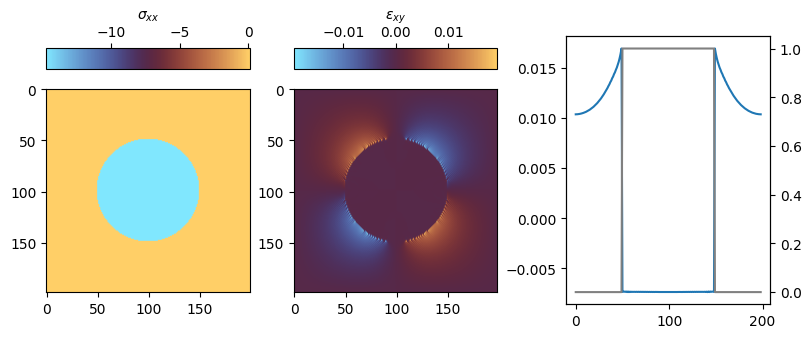

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 3), layout="constrained")
cb1 = ax1.imshow(sig.at[:, :, 0, 0].get(), cmap="managua_r")
divider = make_axes_locatable(ax1)
cax = divider.append_axes("top", size="10%", pad=0.2)
fig.colorbar(
    cb1, cax=cax, label=r"$\sigma_{xx}$", orientation="horizontal", location="top"
)

cb2 = ax2.imshow(eps.at[:, :, 0, 1].get(), cmap="managua_r")
divider = make_axes_locatable(ax2)
cax = divider.append_axes("top", size="10%", pad=0.2)
fig.colorbar(
    cb2, cax=cax, label=r"$\varepsilon_{xy}$", orientation="horizontal", location="top"
)

ax3.plot(eps.at[:, :, 0, 0].get()[:, int(N / 2)])
ax_twin = ax3.twinx()
ax_twin.plot(phase[int(N / 2), :], color="gray")
plt.show()